# Support Vector Regression for Price Prediction

Use Technical Analysis indicators as input features.

Split train/test
Fit SVR to technical indicators.
Report mean squared error.

Prediction for single stock. In this notebook, BTS is chosen arbitrary.
- Predict tomorrow's closing price.
- Use five technical indicators.
- Technical indicator choice and methodology came from Henrique2018.
- Model trained using data from 2014-2016. Model test on holdout data set of 2017, 2018-2020.
- Linear Kernel perform better than RBF. Confirms literature knowledge. RBF was getting 88 MSE on training.


## Linear Kernel


| | In-sample (Training) | Out-of-sample (Holdout) | Out-of-sample (Holdout) |
| --- | --- | --- | --- |
| Year | 2014-2016 | 2017 | 2018-2020 |
| MSE | 0.014 | 0.0118 | 0.13 |
| MAE | 0.089 | 0.086 | 0.21 |
| R2 | 0.96 | 0.30 | 0.96 |



## RBF Kernel

| | In-sample (Training) |
| --- | --- |
| Year | 2014-2016 |
| MSE | 0.0139 |
| MAE | 0.091 |
| R2 | 0.966 |


TODO:
- Try Three-day, Five-day, Ten-day, Twenty-day ahead.
- Instead of price, predict returns instead b/c return is invariant and we would like to predict market invariant.


References
- HENRIQUE, Bruno Miranda; SOBREIRO, Vinicius Amorim; KIMURA, Herbert. Stock price prediction using support vector regression on daily and up to the minute prices. The Journal of finance and data science, 2018, 4.3: 183-201.
- Support Vector Regression in Python Using Scikit-Learn https://heartbeat.fritz.ai/support-vector-regression-in-python-using-scikit-learn-89cc18e933b7
- In-Depth: Support Vector Machines https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html#Fitting-a-support-vector-machine
- Support vector regression for multivariate time series prediction
https://stats.stackexchange.com/questions/14482/support-vector-regression-for-multivariate-time-series-prediction
- SVM From Scratch — Python https://towardsdatascience.com/svm-implementation-from-scratch-python-2db2fc52e5c2
- Support Vector Regression in 6 Steps with Python https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d
- Awad M., Khanna R. (2015) Support Vector Regression. In: Efficient Learning Machines. Apress, Berkeley, CA https://link.springer.com/chapter/10.1007/978-1-4302-5990-9_4

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os, os.path
import talib

In [2]:
DATA_HOME = os.path.join("..","historical")

symbols = ["ADVANC","BTS"]
data = {}
for s in symbols:
    data[s] = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)

df = data["BTS"]
df.index = pd.to_datetime(df.index)
daily = df['2014-01-01':'2016-12-31']

In [3]:
from talib.abstract import *

inputs = {
    'open': daily["Open"],
    'high': daily["High"],
    'low': daily["Low"],
    'close': daily["Close"],
    'volume': daily["Volume"]
}

daily.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
daily.loc[:,"WMA"] = WMA(inputs).tolist()
daily.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
daily.loc[:,"ATR"] = ATR(inputs).tolist()
daily.loc[:,"RSI"] = RSI(inputs).tolist()

daily

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2014-01-02,8.65,8.20,8.60,8.20,42998900.0,5.908451,NaN,NaN,NaN,NaN,NaN
2014-01-03,8.10,7.85,8.00,7.95,78845000.0,5.728316,NaN,NaN,NaN,NaN,NaN
2014-01-06,7.90,7.65,7.90,7.90,70481900.0,5.692288,NaN,NaN,NaN,NaN,NaN
2014-01-07,8.15,7.95,7.95,8.15,49657500.0,5.872424,NaN,NaN,NaN,NaN,NaN
2014-01-08,8.25,7.95,8.15,8.05,53790800.0,5.800371,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,8.50,8.40,8.45,8.50,9327300.0,7.360147,8.520,8.519677,-4.778796e+07,0.141439,49.155341
2016-12-27,8.55,8.45,8.45,8.50,7234400.0,7.360147,8.526,8.519032,-3.982347e+07,0.138479,49.155341
2016-12-28,8.60,8.45,8.50,8.60,20034700.0,7.446738,8.536,8.524839,-2.657028e+07,0.139302,54.605953


# Prepare feature

We want X,y before splitting.

In [4]:
data = daily

# Target: Tomorrow's closing price
data["Tomorrow"] = data["Close"].shift(-1)
data = data.dropna()

# Features: SMA, ATR, RSI AD

features = data[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
target = data[["Tomorrow"]].values

# data[[SMA, WMA, RSI, ADOSC, ATR]]
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Tomorrow
Date,,,,,,,,,,,,
2014-02-12,8.35,8.25,8.30,8.30,36394800.0,6.125488,8.280,8.262151,8.697283e+06,0.184371,52.956830,8.35
2014-02-13,8.45,8.30,8.35,8.35,42877900.0,6.162389,8.290,8.269140,8.431572e+05,0.181916,54.993858,8.40
2014-02-17,8.45,8.35,8.40,8.40,51046400.0,6.199289,8.298,8.279032,-2.446700e+06,0.176065,56.999044,8.40
2014-02-18,8.45,8.25,8.40,8.40,53290700.0,6.199289,8.300,8.287957,4.907902e+06,0.177774,56.999044,8.25
2014-02-19,8.45,8.25,8.40,8.25,76927500.0,6.088587,8.294,8.286129,-1.700650e+07,0.179362,49.349098,8.25
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,8.50,8.40,8.40,8.40,14321400.0,7.273557,8.518,8.520753,-5.663715e+07,0.144626,43.283317,8.50
2016-12-26,8.50,8.40,8.45,8.50,9327300.0,7.360147,8.520,8.519677,-4.778796e+07,0.141439,49.155341,8.50
2016-12-27,8.55,8.45,8.45,8.50,7234400.0,7.360147,8.526,8.519032,-3.982347e+07,0.138479,49.155341,8.60


In [5]:
# Prepare data for training. Split train/test 60/40.
# TODO: get rid of random_state to check when everything is stable?

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## SVR - RBF Kernel

In [6]:
# Use StandardScaler 
# Note about pipeline
# see https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr = SVR(kernel='rbf') # RBF kernel. Note the result here is poorer than linear kernel.
model = make_pipeline(StandardScaler(), svr)

In [7]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [8]:
y_pred = model.predict(X_test)
# y_pred # Check output

In [9]:
mse = mean_squared_error(y_test, y_pred)
mse

0.013966531400053224

In [10]:
rmse = np.sqrt(mse)
rmse

0.11818008038604993

In [11]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.09105708820893402

In [12]:
r2 = r2_score(y_test, y_pred)
r2

0.9662775003004993

In [13]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.013966531400053224,
 'mae': 0.09105708820893402,
 'r2': 0.9662775003004993}

# SVR - Linear Kernel

In [14]:
svr = SVR(kernel='linear')
model = make_pipeline(StandardScaler(), svr)
model.fit(X_train, y_train)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='linear', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [15]:
y_pred = model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)
mse

0.014081717855513176

In [17]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.0897957511008753

In [18]:
r2 = r2_score(y_test, y_pred)
r2

0.96599938005014

In [19]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.014081717855513176,
 'mae': 0.0897957511008753,
 'r2': 0.96599938005014}

# Test on holdout set 1

In [20]:
holdout = df["2017-01-01":"2017-12-31"]
holdout

inputs = {
    'open': holdout["Open"],
    'high': holdout["High"],
    'low': holdout["Low"],
    'close': holdout["Close"],
    'volume': holdout["Volume"]
}

holdout.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout.loc[:,"WMA"] = WMA(inputs).tolist()
holdout.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
holdout.loc[:,"ATR"] = ATR(inputs).tolist()
holdout.loc[:,"RSI"] = RSI(inputs).tolist()

holdout

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI
Date,,,,,,,,,,,
2017-01-04,8.70,8.60,8.60,8.70,21218100.0,7.533327,NaN,NaN,NaN,NaN,NaN
2017-01-05,8.75,8.60,8.75,8.65,26683800.0,7.490033,NaN,NaN,NaN,NaN,NaN
2017-01-06,8.70,8.60,8.65,8.60,18723200.0,7.446738,NaN,NaN,NaN,NaN,NaN
2017-01-09,8.70,8.60,8.65,8.70,15143800.0,7.533327,NaN,NaN,NaN,NaN,NaN
2017-01-10,8.70,8.60,8.70,8.70,27843900.0,7.533327,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,8.50,8.40,8.40,8.40,19085500.0,7.570742,8.292,8.294194,-3.371075e+07,0.106539,55.782958
2017-12-26,8.45,8.40,8.40,8.40,8937200.0,7.570742,8.298,8.300968,-3.449018e+07,0.102501,55.782958
2017-12-27,8.40,8.35,8.40,8.35,9264200.0,7.525679,8.298,8.304409,-3.462126e+07,0.098750,51.875879


In [21]:
# Target: Tomorrow's closing price
data = daily


holdout["Actual"] = holdout["Close"].shift(-1) # tomorrow's price if known today.
holdout.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual
Date,,,,,,,,,,,,
2017-01-04,8.70,8.6,8.60,8.70,21218100.0,7.533327,NaN,NaN,NaN,NaN,NaN,8.65
2017-01-05,8.75,8.6,8.75,8.65,26683800.0,7.490033,NaN,NaN,NaN,NaN,NaN,8.60
2017-01-06,8.70,8.6,8.65,8.60,18723200.0,7.446738,NaN,NaN,NaN,NaN,NaN,8.70
2017-01-09,8.70,8.6,8.65,8.70,15143800.0,7.533327,NaN,NaN,NaN,NaN,NaN,8.70
2017-01-10,8.70,8.6,8.70,8.70,27843900.0,7.533327,NaN,NaN,NaN,NaN,NaN,8.65


In [22]:
# Tomorrow predict
holdout = holdout.dropna()

holdout[0:1]

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual
Date,,,,,,,,,,,,
2017-02-16,8.3,8.25,8.25,8.25,12655000.0,7.284245,8.434,8.402258,-2.091751e+07,0.105516,31.741736,8.25


In [23]:
# Test predicting on one sample.

features = holdout[0:1][["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
features

y_pred = model.predict(features)
y_pred

array([8.08514391])

In [24]:
# Prediction for the holdout set.

holdout.loc[:,"Predict"] = model.predict(holdout[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual,Predict
Date,,,,,,,,,,,,,
2017-02-16,8.30,8.25,8.25,8.25,12655000.0,7.284245,8.434,8.402258,-2.091751e+07,0.105516,31.741736,8.25,8.085144
2017-02-17,8.30,8.20,8.30,8.25,27076000.0,7.284245,8.418,8.387850,-2.056652e+07,0.105122,31.741736,8.35,8.071295
2017-02-20,8.40,8.20,8.25,8.35,17420200.0,7.372540,8.406,8.380860,-1.578182e+07,0.111899,42.496130,8.35,8.268269
2017-02-21,8.40,8.30,8.35,8.35,6444200.0,7.372540,8.396,8.374516,-1.238971e+07,0.111049,42.496130,8.30,8.263627
2017-02-22,8.35,8.25,8.35,8.30,22636800.0,7.328393,8.384,8.365484,-9.875688e+06,0.110260,38.938587,8.30,8.188563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,8.40,8.30,8.30,8.35,28210400.0,7.525679,8.288,8.287419,-3.126536e+07,0.103196,52.712042,8.40,8.366032
2017-12-25,8.50,8.40,8.40,8.40,19085500.0,7.570742,8.292,8.294194,-3.371075e+07,0.106539,55.782958,8.40,8.428812
2017-12-26,8.45,8.40,8.40,8.40,8937200.0,7.570742,8.298,8.300968,-3.449018e+07,0.102501,55.782958,8.35,8.436214


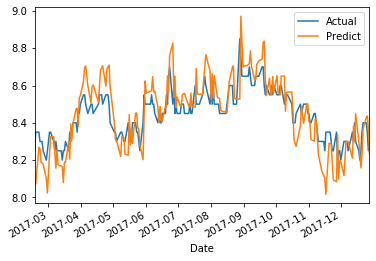

In [25]:
holdout[["Actual", "Predict"]].plot()

In [26]:
mse = mean_squared_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
mse

0.011830915421854597

In [27]:
mae = mean_absolute_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
mae

0.08659917360678591

In [28]:
r2 = r2_score(holdout[["Actual"]].values, holdout[["Predict"]].values)
r2

0.3034363669551111

In [29]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.011830915421854597,
 'mae': 0.08659917360678591,
 'r2': 0.3034363669551111}

# Test on holdout set 2: 2018-2020

In [30]:
holdout2 = df["2018-01-01":"2020-04-30"]
holdout2


inputs = {
    'open': holdout2["Open"],
    'high': holdout2["High"],
    'low': holdout2["Low"],
    'close': holdout2["Close"],
    'volume': holdout2["Volume"]
}

holdout2.loc[:,"SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout2.loc[:,"WMA"] = WMA(inputs).tolist()
holdout2.loc[:,"ADOSC"] = ADOSC(inputs).tolist()
holdout2.loc[:,"ATR"] = ATR(inputs).tolist()
holdout2.loc[:,"RSI"] = RSI(inputs).tolist()

# Tomorrow actual
holdout2.loc[:,"Actual"] = holdout2["Close"].shift(-1)
holdout2.head()

# Start prediction
holdout2 = holdout2.dropna()

holdout2.loc[:,"Predict"] = model.predict(holdout2[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout2

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,Actual,Predict
Date,,,,,,,,,,,,,
2018-02-13,8.05,7.90,8.00,7.90,16821700.0,7.262764,8.118,8.058710,1.209160e+07,0.124727,39.608696,8.00,7.908146
2018-02-14,8.00,7.95,7.95,8.00,12821000.0,7.354698,8.104,8.048925,1.430693e+07,0.122961,46.057188,8.00,8.022131
2018-02-15,8.10,8.00,8.05,8.00,22042700.0,7.354698,8.090,8.039785,6.898985e+06,0.121321,46.057188,8.10,8.010449
2018-02-16,8.15,8.05,8.10,8.10,40342500.0,7.446632,8.078,8.037742,3.241403e+06,0.123369,52.001271,8.15,8.118741
2018-02-19,8.15,8.05,8.10,8.15,23344600.0,7.492599,8.068,8.039247,8.878274e+06,0.121700,54.689677,8.15,8.173660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,11.20,10.90,11.00,11.00,32808400.0,11.000000,9.832,10.165269,-1.812284e+07,0.564428,56.303074,10.90,10.132491
2020-04-24,11.10,10.80,11.10,10.90,31320800.0,10.900000,9.916,10.242043,-2.011012e+07,0.545541,55.082897,11.10,10.188984
2020-04-27,11.10,10.80,11.00,11.10,28191800.0,11.100000,9.982,10.329140,-1.012479e+07,0.528002,57.086005,11.30,10.320447


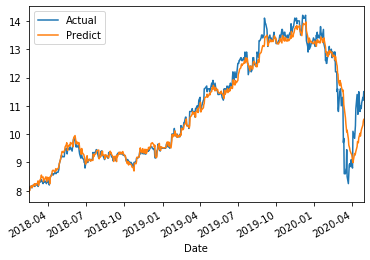

In [36]:
holdout2[["Actual", "Predict"]].plot()

In [32]:
mse = mean_squared_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
mse

0.134876502460245

In [33]:
mae = mean_absolute_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
mae

0.21381628512753972

In [34]:
r2 = r2_score(holdout2[["Actual"]].values, holdout2[["Predict"]].values)
r2

0.9600271553420272

In [35]:
# Report metric

{
    'mse': mse,
    'mae': mae,
    'r2': r2
}

{'mse': 0.134876502460245,
 'mae': 0.21381628512753972,
 'r2': 0.9600271553420272}